In [1]:
import os
import pygmt
import numpy as np
import xesmf as xe
import pandas as pd
import xarray as xr

from mycolorpy import colorlist as mcp

from xarray import DataArray
from scipy.ndimage import gaussian_filter
from numpy import deg2rad, sin, cos, meshgrid, gradient

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
curve = 'foster'

In [3]:
def regridding1(carbdata):
    ds_in = xr.DataArray(
        dims=["latitude", "longitude"],
        coords={"latitude": np.arange(-90,90.05,0.05), "longitude": np.arange(-180,180.05,0.05)},
    )
    ds_out = xe.util.grid_2d(-180.0, 180.0, 0.1, -90.0, 90.0, 0.1)
    regrid = xe.Regridder(ds_in, ds_out, 'nearest_s2d', periodic=True, weights='data/nearest_s2d_gridder_res1.nc')
    return regrid(carbdata)

def getData(timeclim, CO2curve='smooth'):
    abiotic = xr.open_dataset('env_var/enviVar'+str(timeclim)+'Ma_res1_'+CO2curve+'.nc')
    continent = abiotic.flood.fillna(10)
    continent = continent.where(continent>4)
    abiotic['elevation'] = abiotic.bathy.copy()
    shelf = xr.open_dataset('data/shelfs/'+str(timeclim)+'Ma.nc')
    shelf2 = regridding1(shelf)
    abiotic['shelf'] = (('latitude', 'longitude'), shelf2.flood.values)
    shelf.close()
    continent.close()
    shelf2.close()
    dataEM = getEnsemble(xr.open_dataset('photozoan.res2/proj_'+str(timeclim)+'Ma/proj_'+str(timeclim)+'Ma_photozoan.res2_ensemble.tif'))
    return abiotic, dataEM

def getEnsemble(ensemble):
    dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']
    dataName = ['Mean', 'Coefficient of variation', 'Median', 
                'Committee averaging score', 'Weighted mean', 
                'Confidence interval (lower)', 'Confidence interval (upper)']
    nda = xr.DataArray(
                        ensemble.isel(band=4).band_data.values,
                        dims=["latitude", "longitude"],
                        coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                    )
    dataEM = nda.to_dataset(name=dataType[4])
    tmp = nda.fillna(0).values
    dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
    return dataEM

In [4]:
percfile = 'data/percentPhotozoan_foster.csv'
df = pd.read_csv(percfile)
df.head()

Time (Ma)  Shelf Area vs Earth Area (%)  Shelf Area vs Ocean Area (%)   
0        0.0                         10.12                         14.06  \
1        4.0                          8.63                         12.22   
2       10.0                          8.72                         12.42   
3       14.0                          8.75                         12.45   
4       19.0                          9.64                         13.65   

   Photozoan Area vs Shelf Area (%)  Tropic Shelf Area vs Earth Area (%)   
0                             22.66                                 5.35  \
1                             21.62                                 4.20   
2                             21.40                                 4.62   
3                             16.79                                 4.32   
4                             21.89                                 5.33   

   Tropic Shelf Area vs Shelf Area (%)   
0                                52.87  \
1                                48.74   
2                                52.98   
3                                49.37   
4                                55.35   

   Tropic Photozoan Area vs Tropic Shelf Area (%)  PARED totObs  PARED nbObs   
0                                           41.85           117           73  \
1                                           43.07           106           63   
2                                           39.29            87           64   
3                                           32.80           160          102   
4                                           38.62           150           98   

   PARED wmean  SST mean  SST min  SST max  SSS mean  SSS min  SSS max   
0         0.55     28.14    14.34    34.32     32.47     9.32    47.58  \
1         0.45     28.47    15.23    35.13     32.70     7.74    46.49   
2         0.29     28.08    13.34    36.17     32.41     7.31    47.81   
3         0.28     27.60    13.71    34.01     33.95     5.02    46.80   
4         0.39     27.97    13.87    33.68     33.78     5.04    46.79   

   Ocean stream  Current  
0          0.17     9.52  
1          0.39     9.48  
2          0.06     9.13  
3          0.22    10.12  
4          0.25     8.81

In [219]:
df['Time (Ma)'].values

array([  0.,   4.,  10.,  14.,  19.,  25.,  31.,  35.,  39.,  44.,  52.,
        55.,  60.,  66.,  69.,  75.,  80.,  86.,  91.,  97., 102., 107.,
       111., 115., 121., 127., 131., 136., 142., 145., 148., 154., 160.,
       164., 168., 172., 178., 186., 190., 196., 201., 204., 213., 217.,
       222., 227., 232., 233., 239., 244., 252., 256., 262., 265.])

In [66]:
geodata = pd.read_csv('data/PARED_paleomap_time.csv').dropna()
geodata.head()

r_number                name         biota             type       lon   
0         1    Tilkideligi Tepe  Calcisponges  Stromatoporoids   21.3977  \
1         2               Hydra        Corals     Calcisponges   20.9268   
2         3  Shiraho, W-Pacific        Corals            Algae  124.2500   
3         4  Aksu-Terziler area  Calcisponges  Stromatoporoids   26.3043   
4         5     Adnet, Salzburg        Corals     Calcisponges   16.4294   

         lat   time  
0   9.828540  217.0  
1   5.080330  232.0  
2  24.333300    0.0  
3  -0.309389  232.0  
4  32.606900  204.0

In [67]:
timeclims = df['Time (Ma)'].values.copy()

if 'Current' not in df.columns:
    nbObs = []
    totObs = []
    wmean = []
    tmax = []
    tmin = []
    tmean = []
    smax = []
    smin = []
    smean = []
    curr = []
    fstream = []
    for t in range(len(timeclims)):

        timeclim = int(timeclims[t])
        abiotic, dataEM = getData(timeclim, CO2curve=curve)
        shelftropicdata = abiotic.where((abiotic.flood==1)&(abiotic.latitude<30)*(abiotic.latitude>-30)) 
        gdata = geodata.loc[geodata['time'] == timeclim].reset_index(drop=True)
        paredLat = gdata['lat'].values
        paredLon = gdata['lon'].values

        keepIds = []
        score = []
        for k in range(len(paredLat)):
            val = abiotic.flood.sel(longitude=paredLon[k],latitude=paredLat[k],method='nearest').values
            if val == 1:
                keepIds.append(k)
                val = dataEM.wmean.sel(longitude=paredLon[k],latitude=paredLat[k],method='nearest').values
                score.append(val)
        totObs.append(len(paredLon))
        nbObs.append(len(keepIds))
        val = np.asarray(score)
        wmean.append(np.nanmean(val)/1000)
        
        minT,meanT,maxT = shelftropicdata.tempMin.min().values,shelftropicdata.temp.mean().values,shelftropicdata.tempMax.max().values
        tmin.append(minT)
        tmean.append(meanT)
        tmax.append(maxT)
        
        minS,meanS,maxS = shelftropicdata.saltMin.min().values,shelftropicdata.salt.mean().values,shelftropicdata.saltMax.max().values
        smin.append(minS)
        smean.append(meanS)
        smax.append(maxS)
        
        currm,stream = shelftropicdata.curr.mean().values,shelftropicdata.fstream.mean().values
        curr.append(currm)
        fstream.append(stream)
        
        shelftropicdata.close()
        abiotic.close()
        dataEM.close()

    df['SST mean'] = tmean
    df['SST min'] = tmin
    df['SST max'] = tmax
    df['SSS mean'] = smean
    df['SSS min'] = smin
    df['SSS max'] = smax
    df['Ocean stream'] = fstream
    df['Current'] = curr
    df['PARED totObs'] = totObs
    df['PARED nbObs'] = nbObs
    df['PARED wmean'] = wmean
    
    df['Ocean stream'] = df['Ocean stream'].astype(float)
    df['Current'] = df['Current'].astype(float)
    df['SSS max'] = df['SSS max'].astype(float)
    df['SSS mean'] = df['SSS mean'].astype(float)
    df['SSS min'] = df['SSS min'].astype(float)
    df['SST max'] = df['SST max'].astype(float)
    df['SST mean'] = df['SST mean'].astype(float)
    df['SST min'] = df['SST min'].astype(float)
    
    df = df.round(2)
    df.to_csv(percfile,index=False)
    
else:
    
    totObs = df['PARED totObs'] 
    nbObs = df['PARED nbObs'] 
    wmean = df['PARED wmean'] 
    tmean = df['SST mean']
    tmin = df['SST min'] 
    tmax = df['SST max']
    smean = df['SSS mean']  
    smin = df['SSS min']
    smax = df['SSS max']
    fstream = df['Ocean stream']
    curr = df['Current']

In [188]:
EarthArea = 510.070281e+6
ShelfArea = df['Tropic Shelf Area vs Earth Area (%)'].values*EarthArea/100
PhotoArea = (ShelfArea*df['Tropic Photozoan Area vs Tropic Shelf Area (%)'].values/100)/1.e5

array([114.20346074,  92.26865341,  92.58785539,  72.27491854,
       104.99521296,  64.68384859,  78.3855095 ,  79.58698004,
        86.17810821, 108.28807368, 166.78813622, 151.67908939,
       148.58775745, 155.88461886, 198.00969114, 291.02773981,
       296.4171424 , 260.69911392, 256.73571482, 231.14548882,
       208.36835143, 206.95611984, 203.87488729, 206.68685374,
       223.42353484, 162.29569222, 128.24941909, 116.46771372,
       134.57469863, 119.05530026, 115.12204631, 156.7239395 ,
       231.9473193 , 223.4058354 , 195.69866471, 183.03815926,
       109.11474458, 127.99938264, 137.90443742, 154.85060438,
       169.37271334, 167.40430112, 231.96466169, 228.27318105,
       271.02451763, 274.51043994, 257.06317994, 259.02470621,
       278.69546458, 235.56473773, 257.03119853, 286.80905053,
       225.63723985, 225.31589558])

In [286]:
smoothdf = pd.read_csv('data/percentPhotozoan_smooth.csv')
ShelfSmoothArea = smoothdf['Tropic Shelf Area vs Earth Area (%)'].values*EarthArea/100
PhotoSmoothArea = (ShelfArea*smoothdf['Tropic Photozoan Area vs Tropic Shelf Area (%)'].values/100)/1.e5

s_totObs = smoothdf['PARED totObs'] 
s_nbObs = smoothdf['PARED nbObs'] 
s_wmean = smoothdf['PARED wmean'] 
s_tmean = smoothdf['SST mean']
s_tmin = smoothdf['SST min'] 
s_tmax = smoothdf['SST max']
s_smean = smoothdf['SSS mean']  
s_smin = smoothdf['SSS min']
s_smax = smoothdf['SSS max']
s_fstream = smoothdf['Ocean stream']
s_curr = smoothdf['Current']

In [327]:
arr1 = np.nan_to_num(smoothdf['PARED wmean'].values)
arr2 = np.nan_to_num(df['PARED wmean'].values)

colorMaxwmean = np.maximum(arr1,arr2)

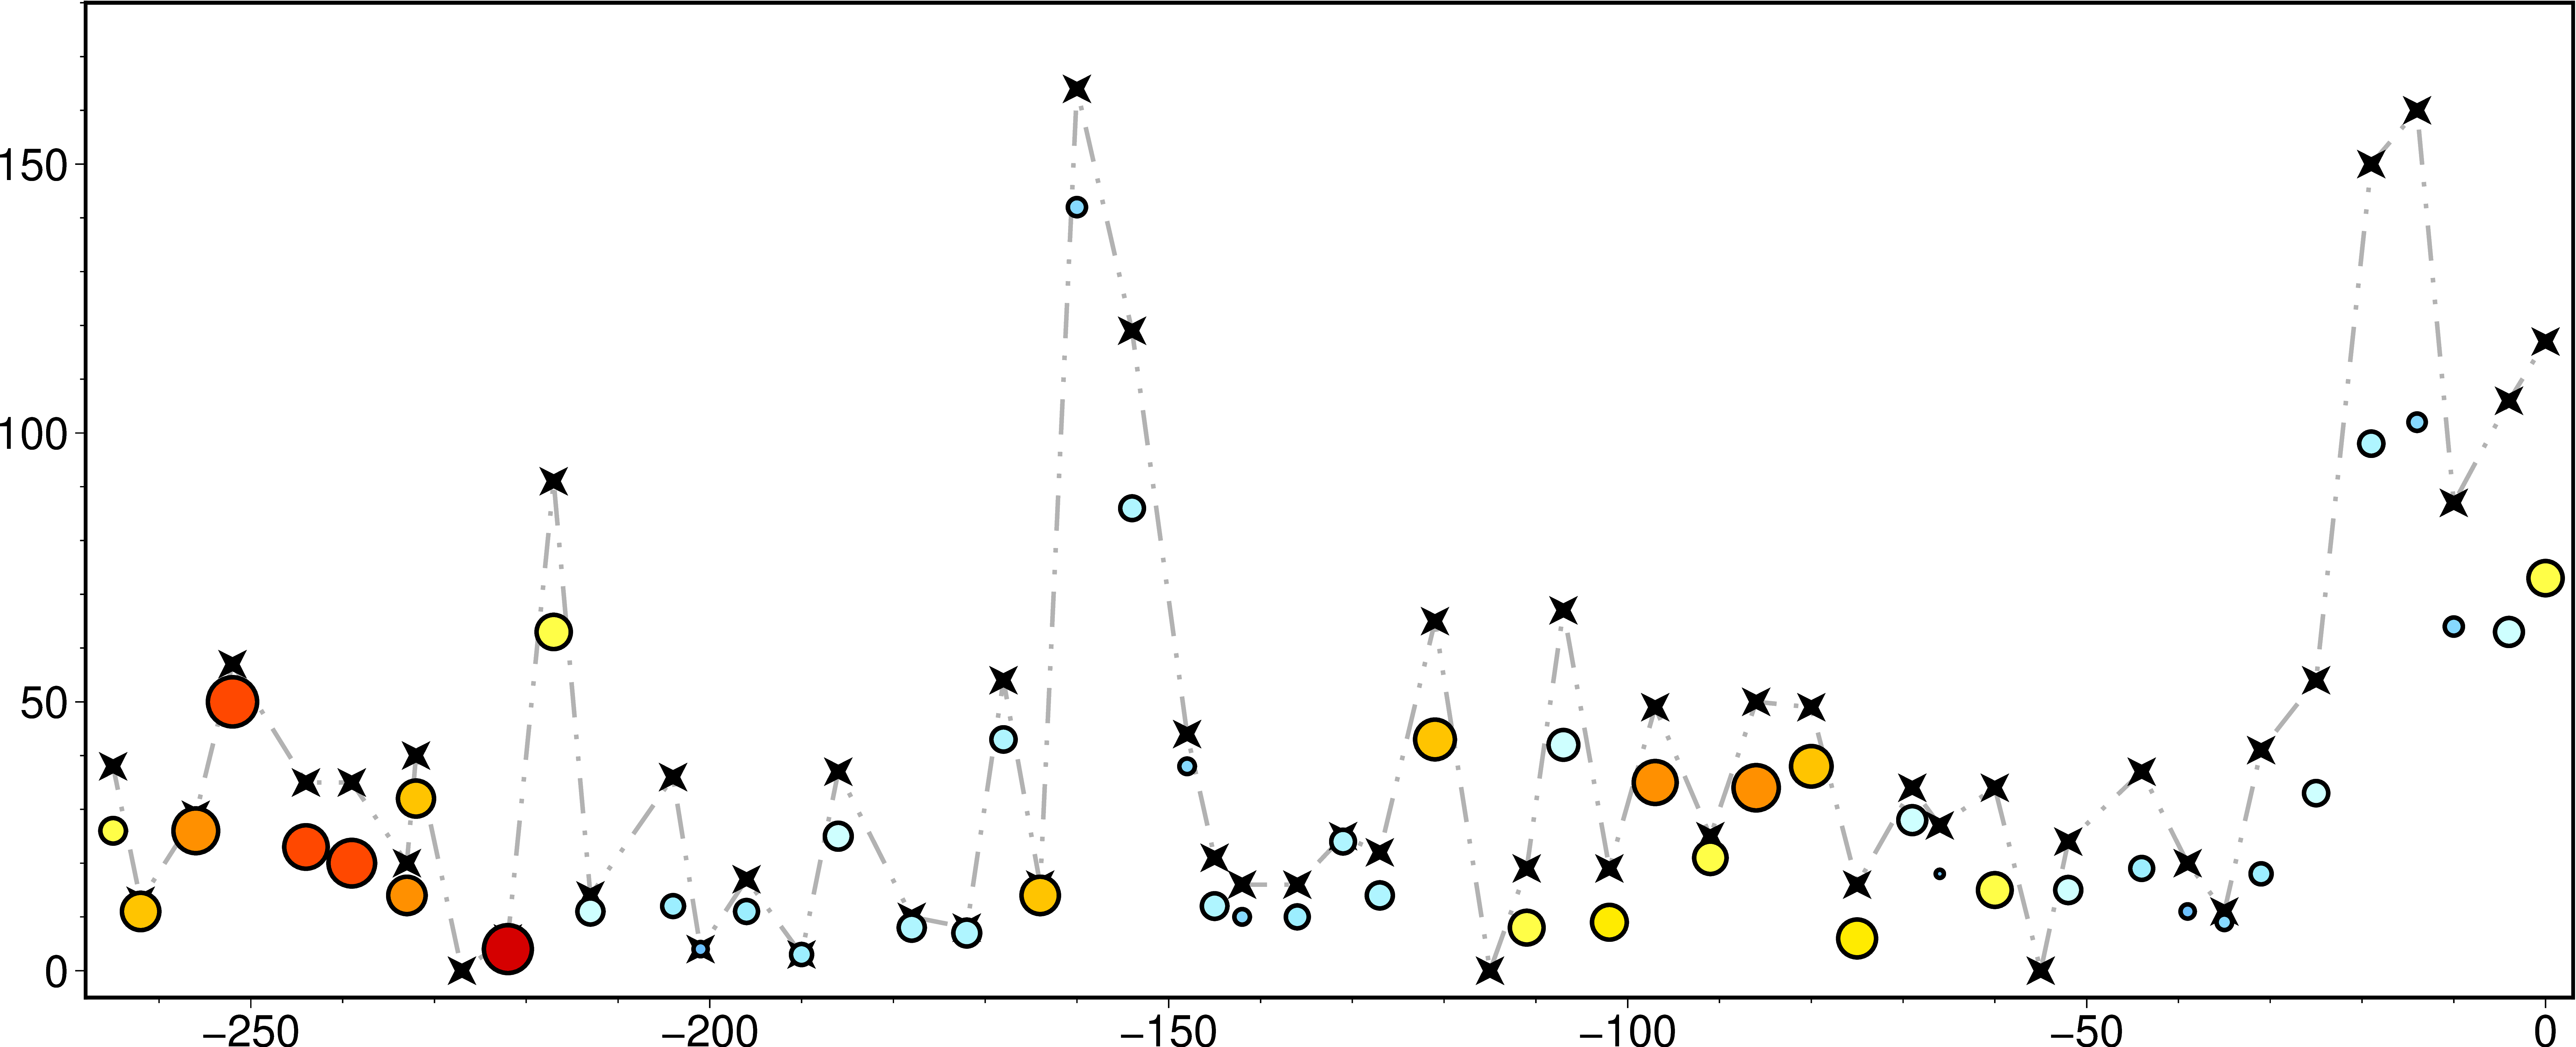

In [329]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-268, 3, -5, 180], projection="X40c/16c", frame='af')
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=totObs,
        transparency=70,
        pen="2p,..-",
    )
    
    fig.plot(
        x=-df['Time (Ma)'],
        y=totObs,
        style="kstar4/0.3c", #style="c0.8c",
        fill="black", 
        pen="2p,black",
#         fill=df['PARED wmean'],
#         cmap=True,
#         sizes=sizes,
#         color=color,
        # Set the legend label,
        # and set the circle size to be 0.25 cm (+S0.25c) in legend
#         label=f"{color}+S0.25c",
#         transparency=70,  # set transparency level for all symbols
    )
    
    
    sz = np.nan_to_num(np.asarray(df['PARED wmean']))
    pygmt.makecpt(cmap="panoply", series=[0, 1], reverse=False)
    fig.plot(
        x=-df['Time (Ma)'],
        y=nbObs,
        style="c",
#         fill="white", 
        pen="2p,black",
        fill=colorMaxwmean,
        cmap=True,
        size=sz,
#         transparency=30,
#         color=color,
        # Set the legend label,
        # and set the circle size to be 0.25 cm (+S0.25c) in legend
#         label=f"{color}+S0.25c",
#         transparency=70,  # set transparency level for all symbols
    )
    
#     sz2 = np.nan_to_num(np.asarray(smoothdf['PARED wmean']))
#     pygmt.makecpt(cmap="panoply", series=[0, 1], reverse=False)
#     fig.plot(
#         x=-smoothdf['Time (Ma)'],
#         y=s_nbObs,
#         style="t",
# #         fill="white", 
#         pen="2p,black",
#         fill=smoothdf['PARED wmean'],
#         cmap=True,
#         size=1.5*sz2,
# #         transparency=30,
# #         color=color,
#         # Set the legend label,
#         # and set the circle size to be 0.25 cm (+S0.25c) in legend
# #         label=f"{color}+S0.25c",
# #         transparency=70,  # set transparency level for all symbols
#     )
fig.show(dpi=500, width=1000)
fig.savefig('predictPARED.png',dpi=500, transparent=True)


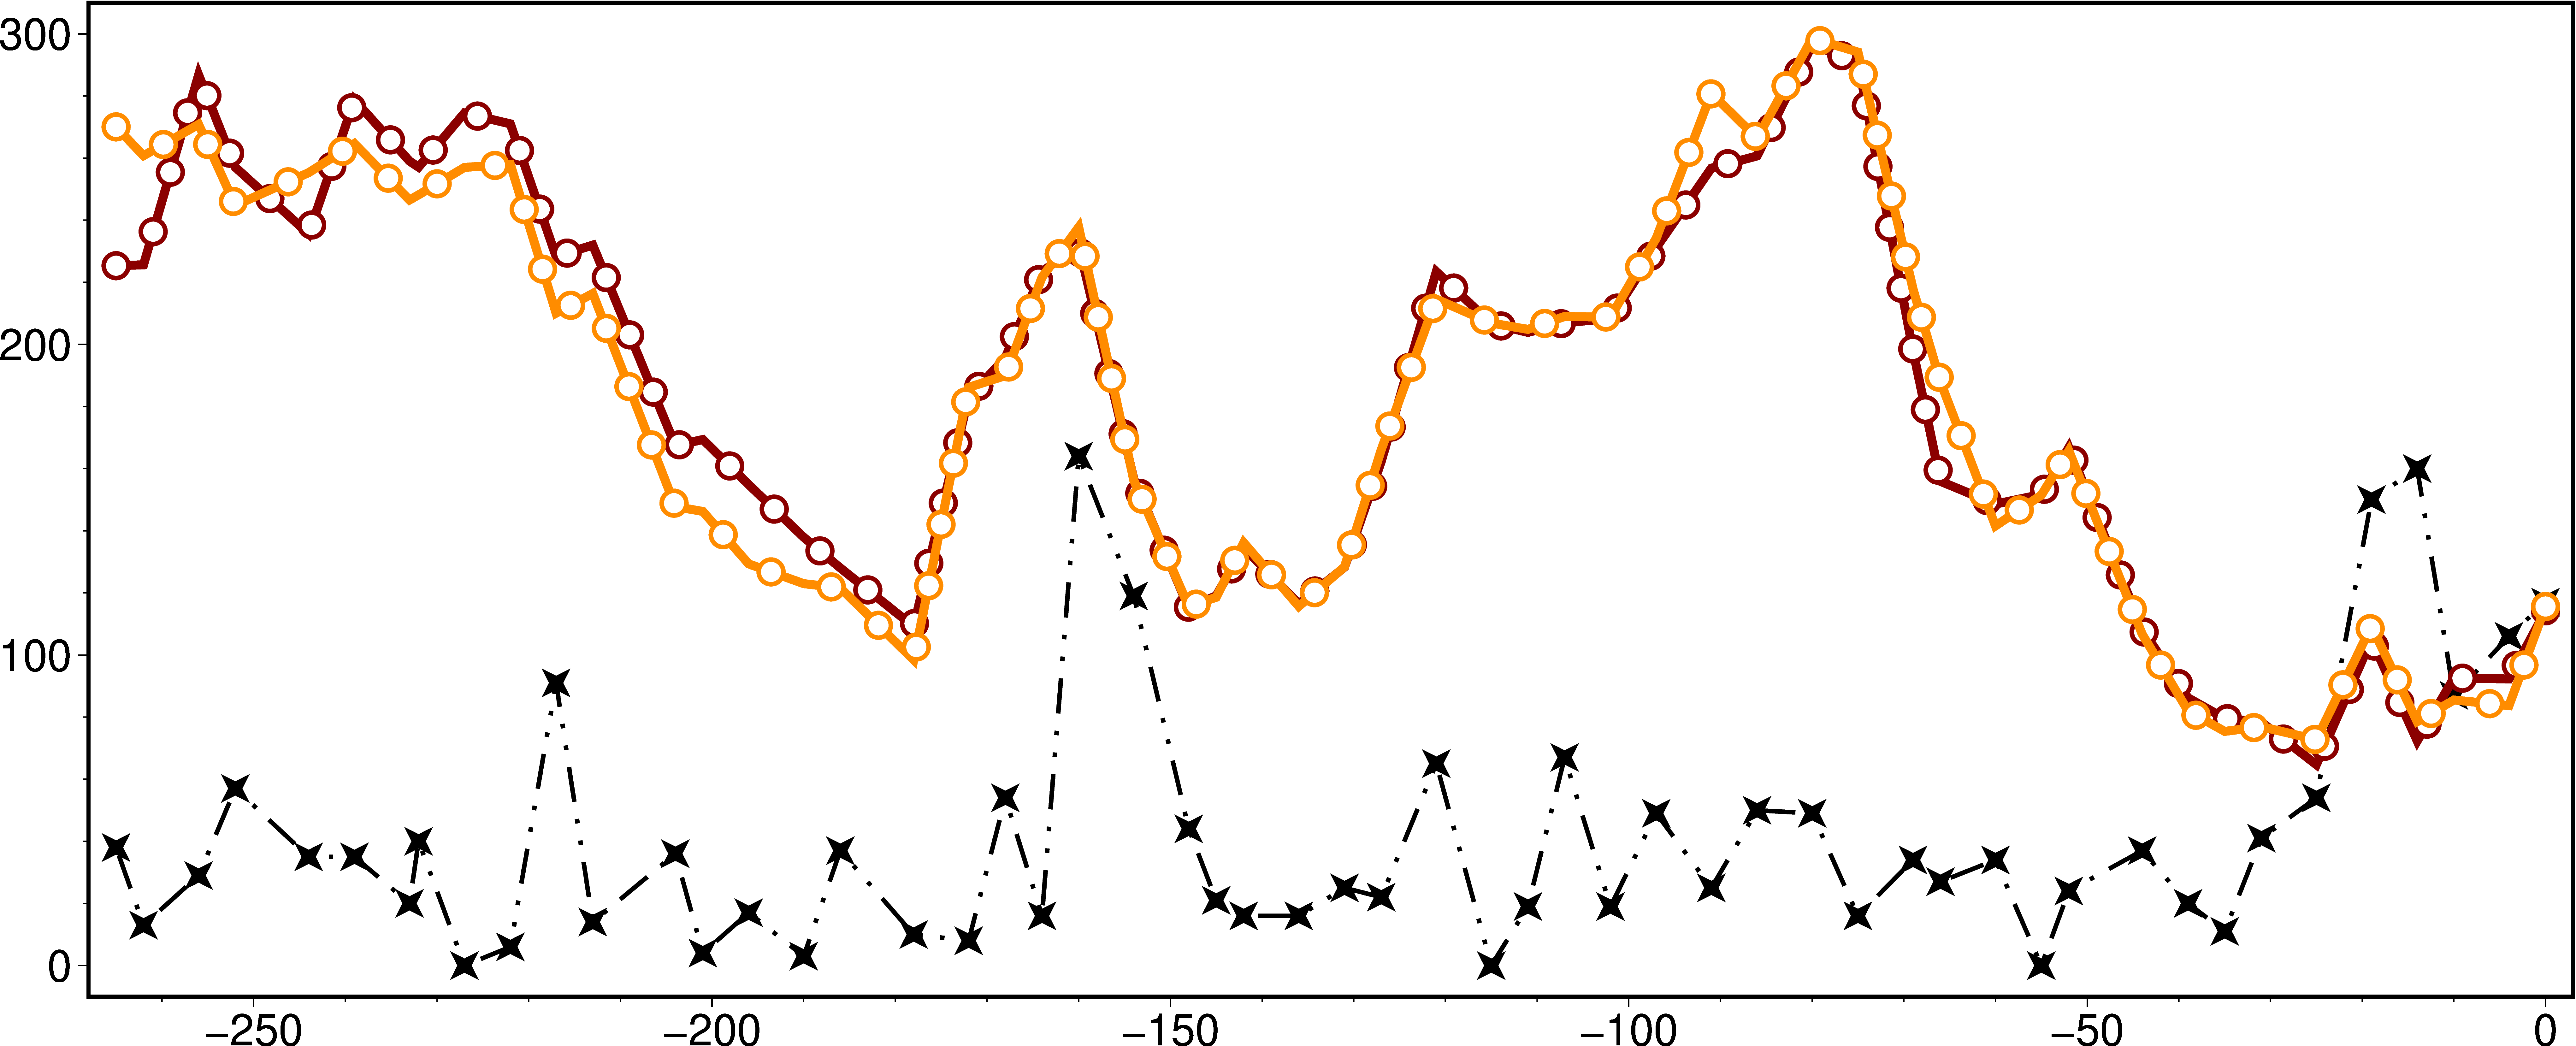

In [314]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-268, 3, -10, 310], projection="X40c/16c", frame='af')
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=totObs,
#         transparency=1,
        pen="2p,..-",
    )
    
    fig.plot(
        x=-df['Time (Ma)'],
        y=totObs,
        style="kstar4/0.3c", #style="c0.8c",
        fill="black", 
        pen="2p,black",
#         fill=df['PARED wmean'],
#         cmap=True,
#         sizes=sizes,
#         color=color,
        # Set the legend label,
        # and set the circle size to be 0.25 cm (+S0.25c) in legend
#         label=f"{color}+S0.25c",
#         transparency=70,  # set transparency level for all symbols
    )
    
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=PhotoArea,
#         transparency=1,
#         ='f1c/0.25c+c',
        style='f1c/0.4c+c+p2p,darkred', fill="white",
        pen="4p,darkred",
    )
    
    fig.plot(
        frame="a",
        x=-smoothdf['Time (Ma)'],
        y=PhotoSmoothArea,
#         transparency=1,
#         ='f1c/0.25c+c',
        style='f1c/0.4c+c+p2p,darkorange', fill="white",
        pen="4p,darkorange",
    )
    
fig.show(dpi=500, width=1000)
fig.savefig('areaFosterSmooth.png',dpi=500, transparent=True)


#     fig.plot(x=sCO2time,y=sCO2SST,transparency=0,pen="6p,darkorange")
#     fig.plot(x=-df['Time (Ma)'],y=tmean,transparency=0,pen="6p,darkred")

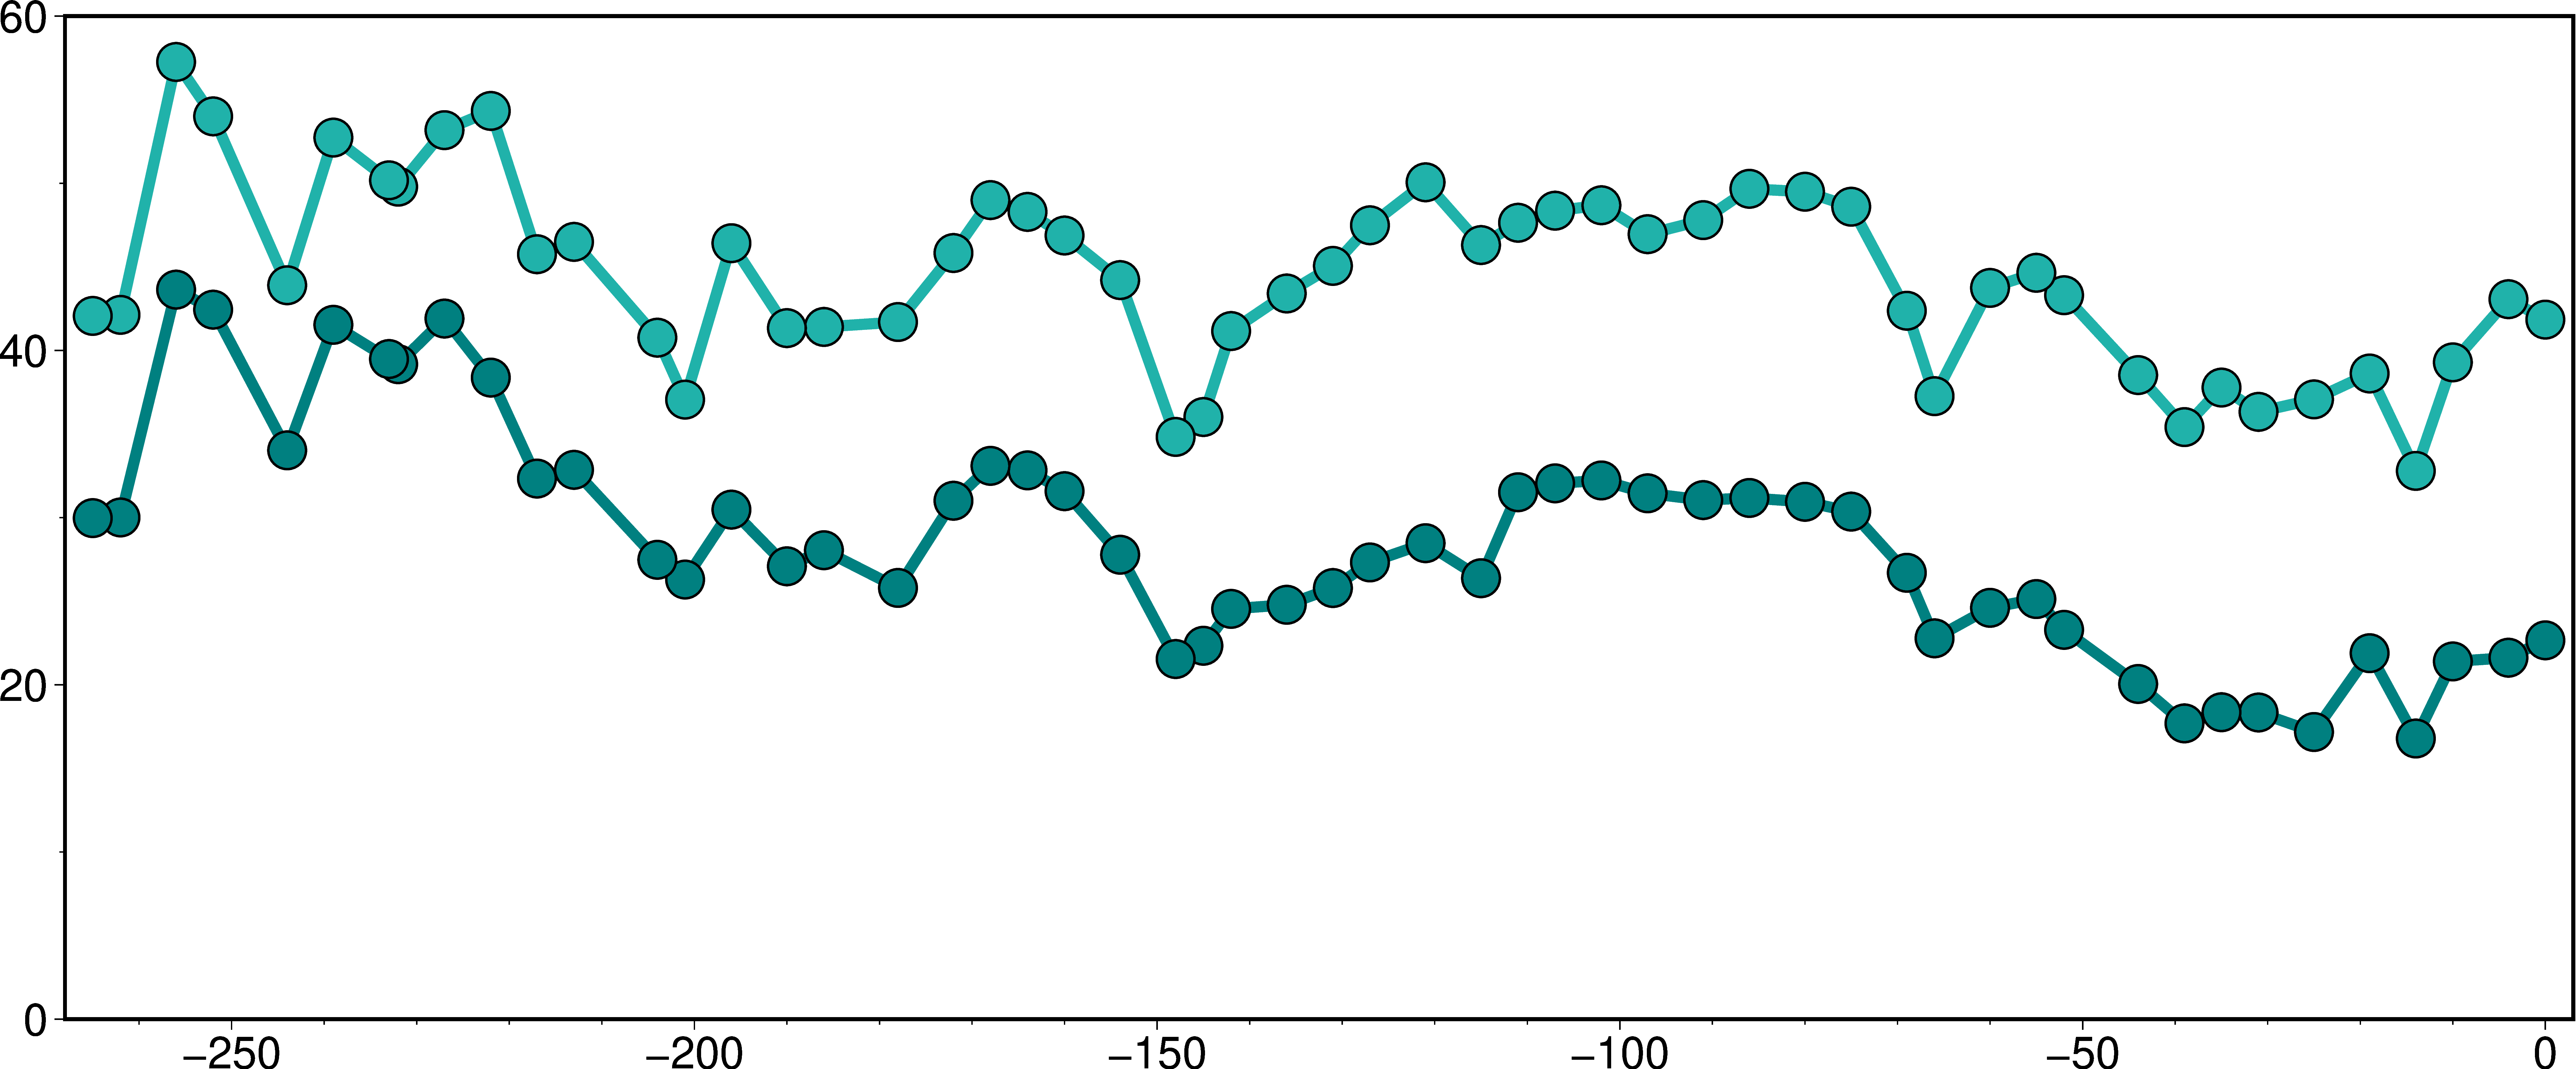

In [173]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-268, 3, 0, 60], projection="X40c/16c", frame='af')
#     fig.plot(
#         frame="a",
#         x=-df['Time (Ma)'],
#         y=df['Shelf Area vs Ocean Area (%)'],
#         transparency=0,
#         pen="5p",
#     )
#     fig.plot(
#         x=-df['Time (Ma)'],
#         y=df['Shelf Area vs Ocean Area (%)'],
#         style="kstar4/0.6c", 
#         fill="white", 
#         pen="1p,black",
#     )
    
    
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=df['Photozoan Area vs Shelf Area (%)'],
        transparency=0,
        pen="5p,#008080",
    )
    fig.plot(
        x=-df['Time (Ma)'],
        y=df['Photozoan Area vs Shelf Area (%)'],
        style="c0.6c", 
        fill="#008080", 
        pen="1p,black",
    )
    
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=df['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        transparency=0,
        pen="5p,lightseagreen",
    )
    fig.plot(
        x=-df['Time (Ma)'],
        y=df['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        style="c0.6c", 
        fill="lightseagreen", 
        pen="1p,black",
    )
    
fig.show(dpi=500, width=1000)
fig.savefig('percentageFoster.png',dpi=500, transparent=True)


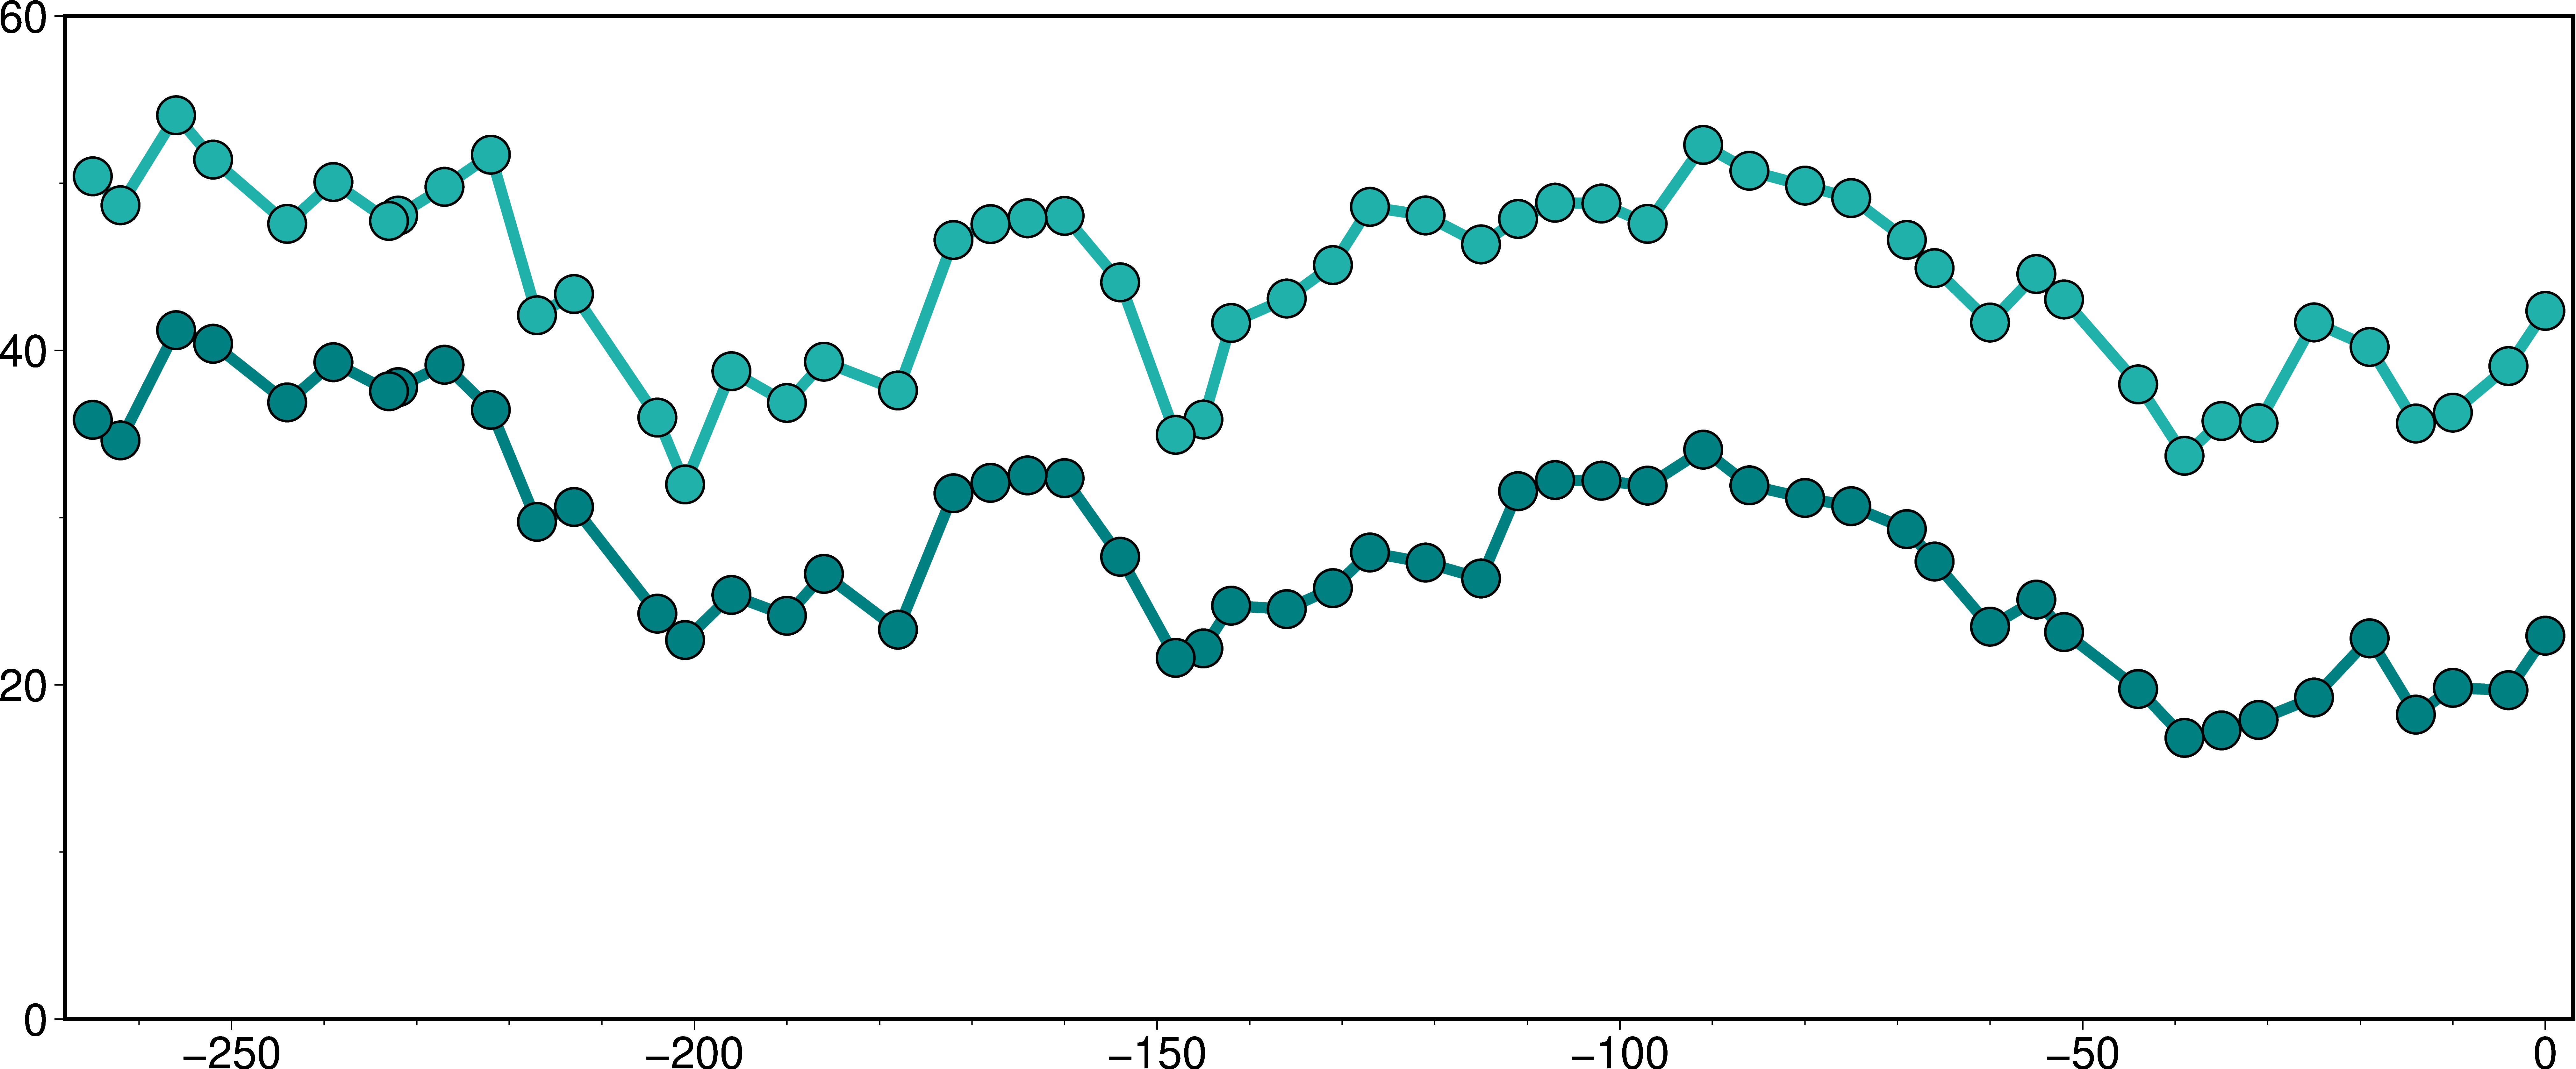

In [292]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-268, 3, 0, 60], projection="X40c/16c", frame='af')
    
    fig.plot(
        frame="a",
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Photozoan Area vs Shelf Area (%)'],
        transparency=0,
        pen="5p,#008080",
    )
    fig.plot(
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Photozoan Area vs Shelf Area (%)'],
        style="c0.6c", 
        fill="#008080", 
        pen="1p,black",
    )
    
    fig.plot(
        frame="a",
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        transparency=0,
        pen="5p,lightseagreen",
    )
    fig.plot(
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        style="c0.6c", 
        fill="lightseagreen", 
        pen="1p,black",
    )
    
fig.show(dpi=500, width=1000)
fig.savefig('percentageSmooth.png',dpi=500, transparent=True)


In [339]:

df_bound = pd.DataFrame(
    data={
        "x": -df['Time (Ma)'],
        "y": smoothdf['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        "y_bound_low": smoothdf['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        "y_bound_upp": df['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
    }
)


df_bound2 = pd.DataFrame(
    data={
        "x": -df['Time (Ma)'],
        "y": smoothdf['Photozoan Area vs Shelf Area (%)'],
        "y_bound_low": smoothdf['Photozoan Area vs Shelf Area (%)'],
        "y_bound_upp": df['Photozoan Area vs Shelf Area (%)'],
    }
)
# df_bound2 = pd.DataFrame(
#     data={
#         "x": -smoothCO2['Time (Ma)'],
#         "y": smoothCO2['SST mean'],
#         "y_bound_low": smoothCO2['SST min'],
#         "y_bound_upp": smoothCO2['SST max'],
#     }
# )

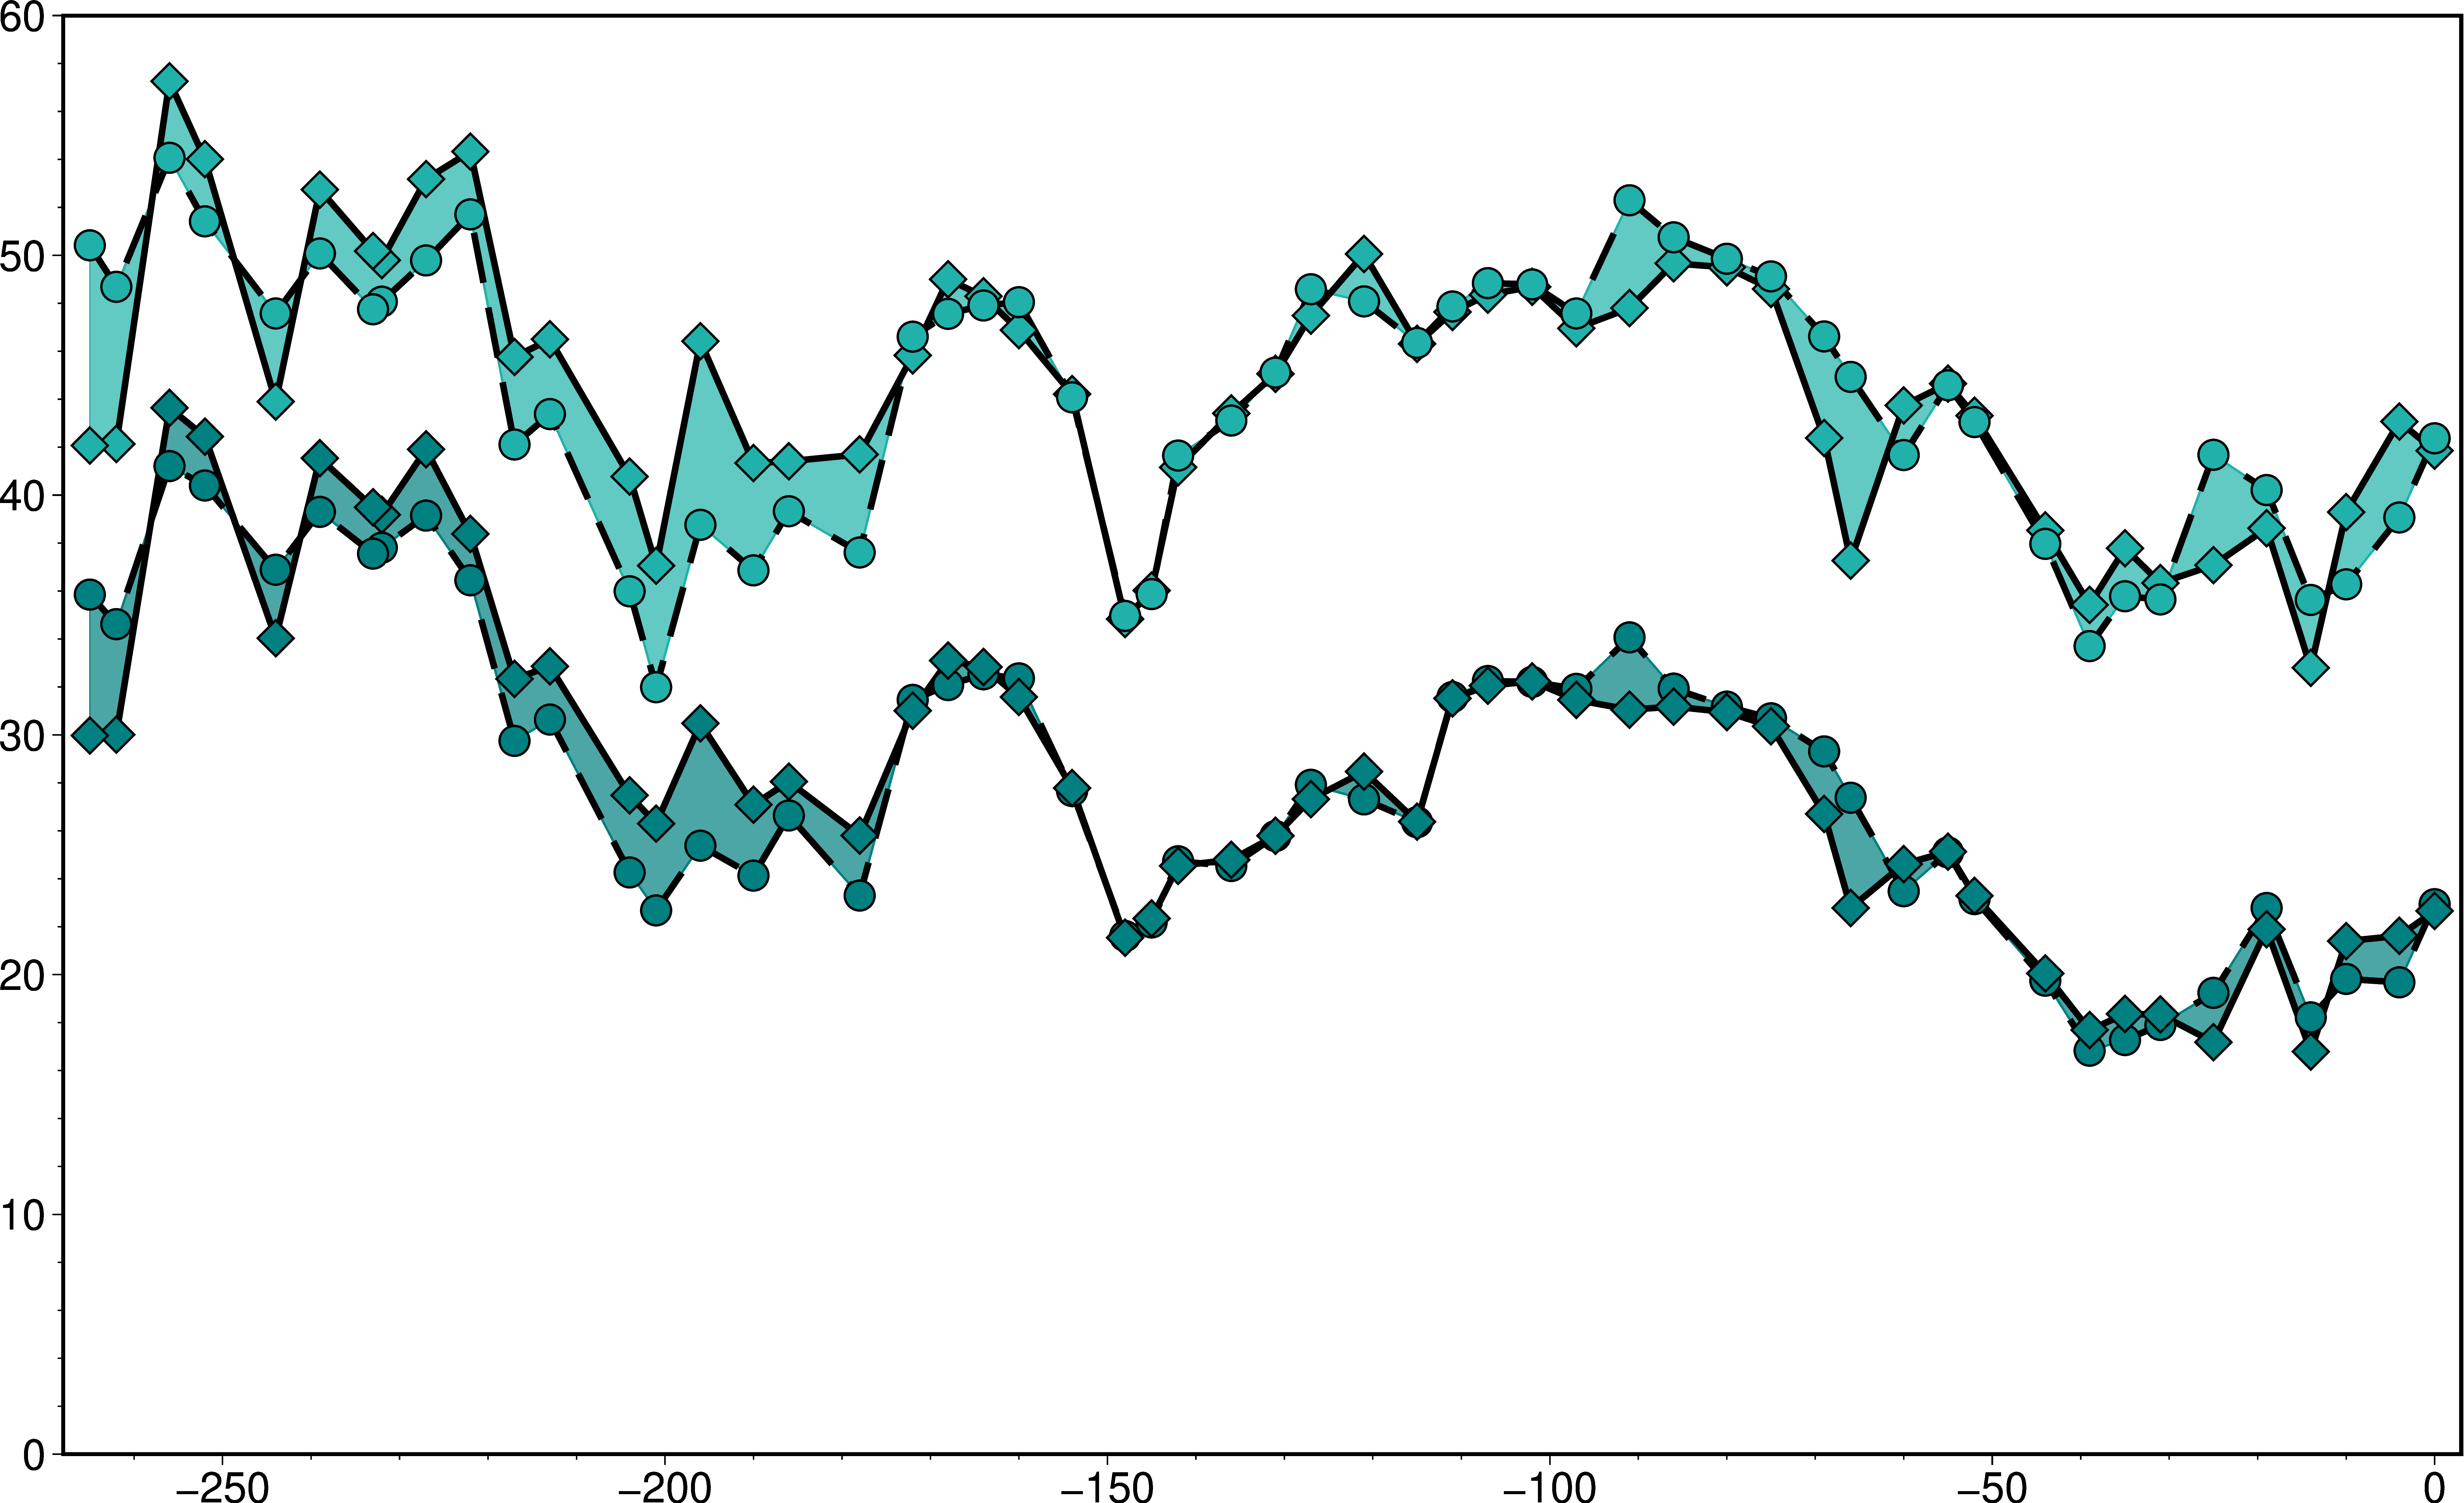

In [353]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-268, 3, 0, 60], projection="X40c/24c", frame='af')
    
    fig.plot(data=df_bound2, close="+b+p0.5p,#008080", 
             fill="#008080@30", pen="1p,#008080")
    fig.plot(
        frame="a",
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Photozoan Area vs Shelf Area (%)'],
        transparency=0,
        pen="3p,black,-",
    )
    
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=df['Photozoan Area vs Shelf Area (%)'],
        transparency=0,
        pen="3p,black",
    )
    
    fig.plot(
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Photozoan Area vs Shelf Area (%)'],
        style="c0.5c", 
        fill="#008080", 
        pen="1p,black",
    )
    fig.plot(
        x=-df['Time (Ma)'],
        y=df['Photozoan Area vs Shelf Area (%)'],
        style="d0.6c", 
        fill="#008080", 
        pen="1p,black",
    )
    
    fig.plot(data=df_bound, close="+b+p0.5p,lightseagreen", 
             fill="lightseagreen@30", pen="1p,lightseagreen")
    fig.plot(
        frame="a",
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        transparency=0,
        pen="3p,black,-",
    )
    
    
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=df['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        transparency=0,
        pen="3p,black",
    )
    
    fig.plot(
        x=-df['Time (Ma)'],
        y=df['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        style="d0.6c", 
        fill="lightseagreen", 
        pen="1p,black",
    )
    
    fig.plot(
        x=-smoothdf['Time (Ma)'],
        y=smoothdf['Tropic Photozoan Area vs Tropic Shelf Area (%)'],
        style="c0.5c", 
        fill="lightseagreen", 
        pen="1p,black",
    )
    
fig.show(dpi=500, width=1000)
fig.savefig('percentageSmoothFoster.png',dpi=500, transparent=True)


In [293]:
# fig = pygmt.Figure()
# pygmt.config(
#     MAP_FRAME_WIDTH="0.5p",
#     MAP_FRAME_TYPE="fancy",
# )
# font = "4p,Helvetica-Bold"

# with pygmt.config(FONT='20p,Helvetica,black'):
#     fig.basemap(region=[-268, 3, 0, 50], projection="X40c/16c", frame='af')
#     fig.plot(
#         frame="a",
#         x=-df['Time (Ma)'],
#         y=tmin,
#         transparency=0,
#         pen="2p,..-",
#     )
    
#     fig.plot(
#         frame="a",
#         x=-df['Time (Ma)'],
#         y=tmax,
#         transparency=0,
#         pen="2p,..-",
#     )
    
#     fig.plot(
#         frame="a",
#         x=-df['Time (Ma)'],
#         y=tmean,
#         transparency=0,
#         pen="5p",
#     )
# fig.show(dpi=500, width=1000)

## SST database

Cramwinckel, M.J., Huber, M., Kocken, I.J. et al. Synchronous tropical and polar temperature evolution in the Eocene. Nature 559, 382–386 (2018). https://doi.org/10.1038/s41586-018-0272-2

Table 5 shows Eocene tropical sea surface temperature compilation from TEX86

In [109]:
SST1 = pd.read_excel('data/41586_2018_272_MOESM1_ESM.xlsx')
SST1time = (-SST1['Age (Ma, GTS2012)']).to_list()
SST1val = (SST1['SST (TEXH86)']).to_list()

/Users/galois/conda/anaconda3/envs/reefmodel/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Supplementary material 1: Cretaceous GDGT data compilation
    
O'Brien C. et al., Cretaceous sea-surface temperature evolution: Constraints from TEX86 and planktonic foraminiferal oxygen isotopes, Earth-Science Reviews, 172 (2017). https://doi.org/10.1016/j.earscirev.2017.07.012.

A new compilation and synthesis of available planktonic foraminiferal δ18O (δ18Opl) and TEX86-SST proxy data for almost the entire Cretaceous Period.

In [125]:
SST2 = pd.read_excel('data/OBrien2017.xlsx')
SST2time = (-SST2['Age']).to_list()
SST2val = (SST2['SST']).to_list()

From https://www.nature.com/articles/s41598-022-11493-1#Sec10  Table S1 

Grossman, E.L., Joachimski, M.M. Ocean temperatures through the Phanerozoic reassessed. Sci Rep 12, 8938 (2022). https://doi.org/10.1038/s41598-022-11493-1

**Oxygen and carbon isotopic compositions of biogenic carbonates and sample information.**  

Paleolatitudes were reconstructed using the GPlates software80 with the Paleomap81 rotation model. For paleolatitudinal corrections of δ18Osw during icehouse climates, we use the modern latitude-δ18O relationship of Roberts et al.82; Supplementary Fig. S2, Supplementary Table S8) derived from gridded data modeled in LeGrande and Schmidt83. 

In [142]:
SST3 = pd.read_excel('data/GrossmanSUP1.xlsx')
SST3_tropics = SST3.loc[SST3['climzone'] == 'Tropical'][['age','Temp']]
SST3_tropics = SST3_tropics.dropna()
SST3time = (-SST3['age']).to_list()
SST3val = (SST3['Temp']).to_list()

In [281]:
smoothCO2 = pd.read_csv('data/percentPhotozoan_smooth.csv')
sCO2time = (-smoothCO2['Time (Ma)']).to_list()
sCO2SST = (smoothCO2['SST mean']).to_list()

In [311]:
comb = smoothdf[['SST min','SST max']]
comb['SST min2'] = tmin
comb['SST max2'] = tmax
minSST = comb[['SST min','SST min2']].min(axis=1)
maxSST = comb[['SST max','SST max2']].max(axis=1)

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_57448/1699966891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb['SST min2'] = tmin
/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_57448/1699966891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb['SST max2'] = tmax


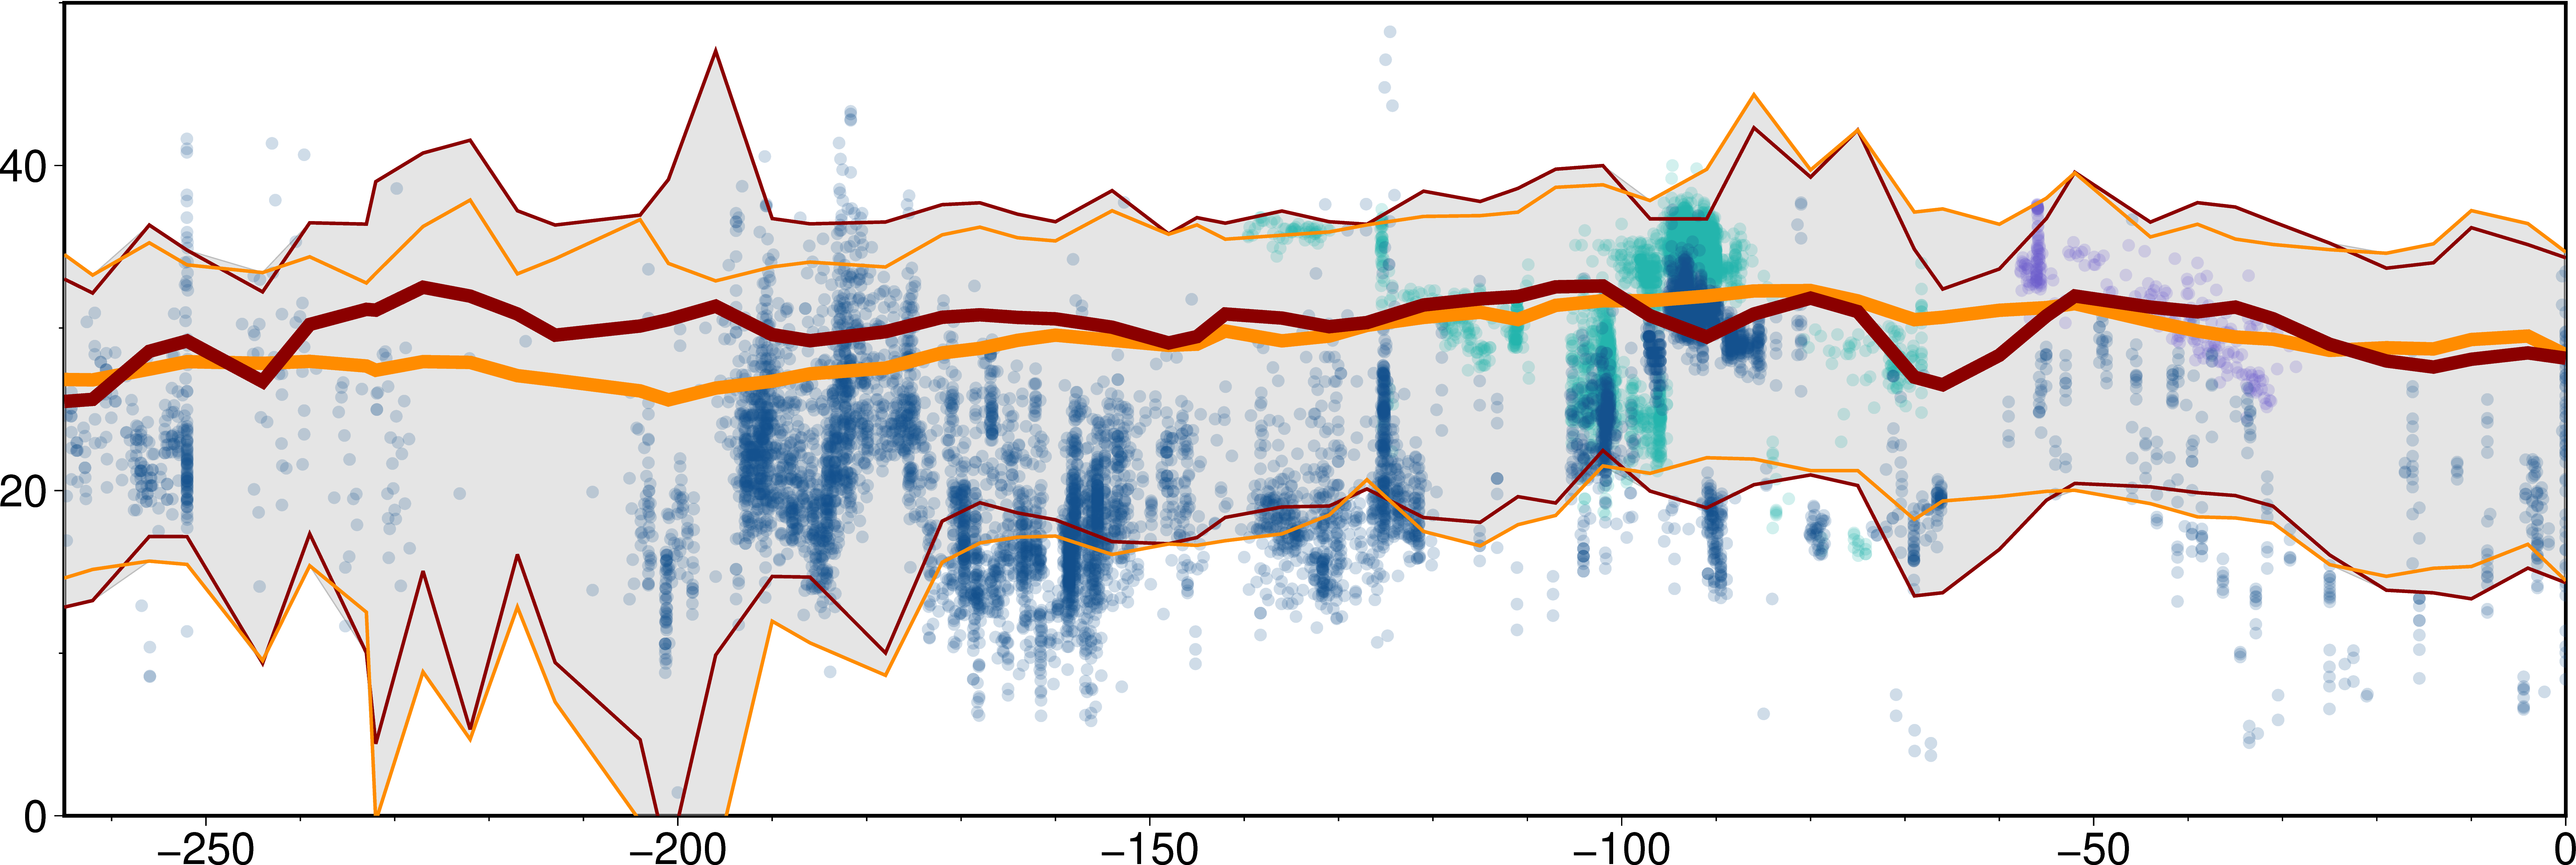

In [313]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

df_bound = pd.DataFrame(
    data={
        "x": -df['Time (Ma)'],
        "y": tmean,
        "y_bound_low": minSST,
        "y_bound_upp": maxSST,
    }
)

# df_bound2 = pd.DataFrame(
#     data={
#         "x": -smoothCO2['Time (Ma)'],
#         "y": smoothCO2['SST mean'],
#         "y_bound_low": smoothCO2['SST min'],
#         "y_bound_upp": smoothCO2['SST max'],
#     }
# )

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-265, 0, 0, 50], projection="X40c/13c", frame='af')
    fig.plot(data=df_bound, close="+b+p0.5p,gray", 
             fill="gray@60", pen="1p,gray")
    
#     fig.plot(data=df_bound2, close="+b+p3p,darkorange", 
#              fill="gray@50", pen="1p,darkorange")
    
    fig.plot(
        x=SST1time,
        y=SST1val,
        style="c0.2c", 
        fill="slateblue", 
#         pen="0.1p,black",
        transparency=80,
    )
    
    
    fig.plot(
        x=SST2time,
        y=SST2val,
        style="c0.2c", 
        fill="lightseagreen", 
#         pen="0.1p,black",
        transparency=80,
    )
    
    
    fig.plot(
        x=SST3time,
        y=SST3val,
        style="c0.2c", 
        fill="dodgerblue4", 
#         pen="0.5p,black",
        transparency=80,
    )
    
    
    fig.plot(x=-df['Time (Ma)'],y=tmin,transparency=0,pen="1.5p,darkred")
    fig.plot(x=-df['Time (Ma)'],y=tmax,transparency=0,pen="1.5p,darkred")
    
    fig.plot(x=-df['Time (Ma)'],y=smoothdf['SST min'],transparency=0,pen="1.5p,darkorange")
    fig.plot(x=-df['Time (Ma)'],y=smoothdf['SST max'],transparency=0,pen="1.5p,darkorange")
    
    fig.plot(x=sCO2time,y=sCO2SST,transparency=0,pen="6p,darkorange")
    fig.plot(x=-df['Time (Ma)'],y=tmean,transparency=0,pen="6p,darkred")
fig.show(dpi=500, width=1000)
fig.savefig('SST.png',dpi=500, transparent=True)

In [6]:
df.head()

Time (Ma)  Shelf Area vs Earth Area (%)  Shelf Area vs Ocean Area (%)   
0        0.0                         10.12                         14.06  \
1        4.0                          8.63                         12.22   
2       10.0                          8.72                         12.42   
3       14.0                          8.75                         12.45   
4       19.0                          9.64                         13.65   

   Photozoan Area vs Shelf Area (%)  Tropic Shelf Area vs Earth Area (%)   
0                             22.66                                 5.35  \
1                             21.62                                 4.20   
2                             21.40                                 4.62   
3                             16.79                                 4.32   
4                             21.89                                 5.33   

   Tropic Shelf Area vs Shelf Area (%)   
0                                52.87  \
1                                48.74   
2                                52.98   
3                                49.37   
4                                55.35   

   Tropic Photozoan Area vs Tropic Shelf Area (%)  PARED totObs  PARED nbObs   
0                                           41.85           117           73  \
1                                           43.07           106           63   
2                                           39.29            87           64   
3                                           32.80           160          102   
4                                           38.62           150           98   

   PARED wmean  SST mean  SST min  SST max  SSS mean  SSS min  SSS max   
0         0.55     28.14    14.34    34.32     32.47     9.32    47.58  \
1         0.45     28.47    15.23    35.13     32.70     7.74    46.49   
2         0.29     28.08    13.34    36.17     32.41     7.31    47.81   
3         0.28     27.60    13.71    34.01     33.95     5.02    46.80   
4         0.39     27.97    13.87    33.68     33.78     5.04    46.79   

   Ocean stream  Current  
0          0.17     9.52  
1          0.39     9.48  
2          0.06     9.13  
3          0.22    10.12  
4          0.25     8.81

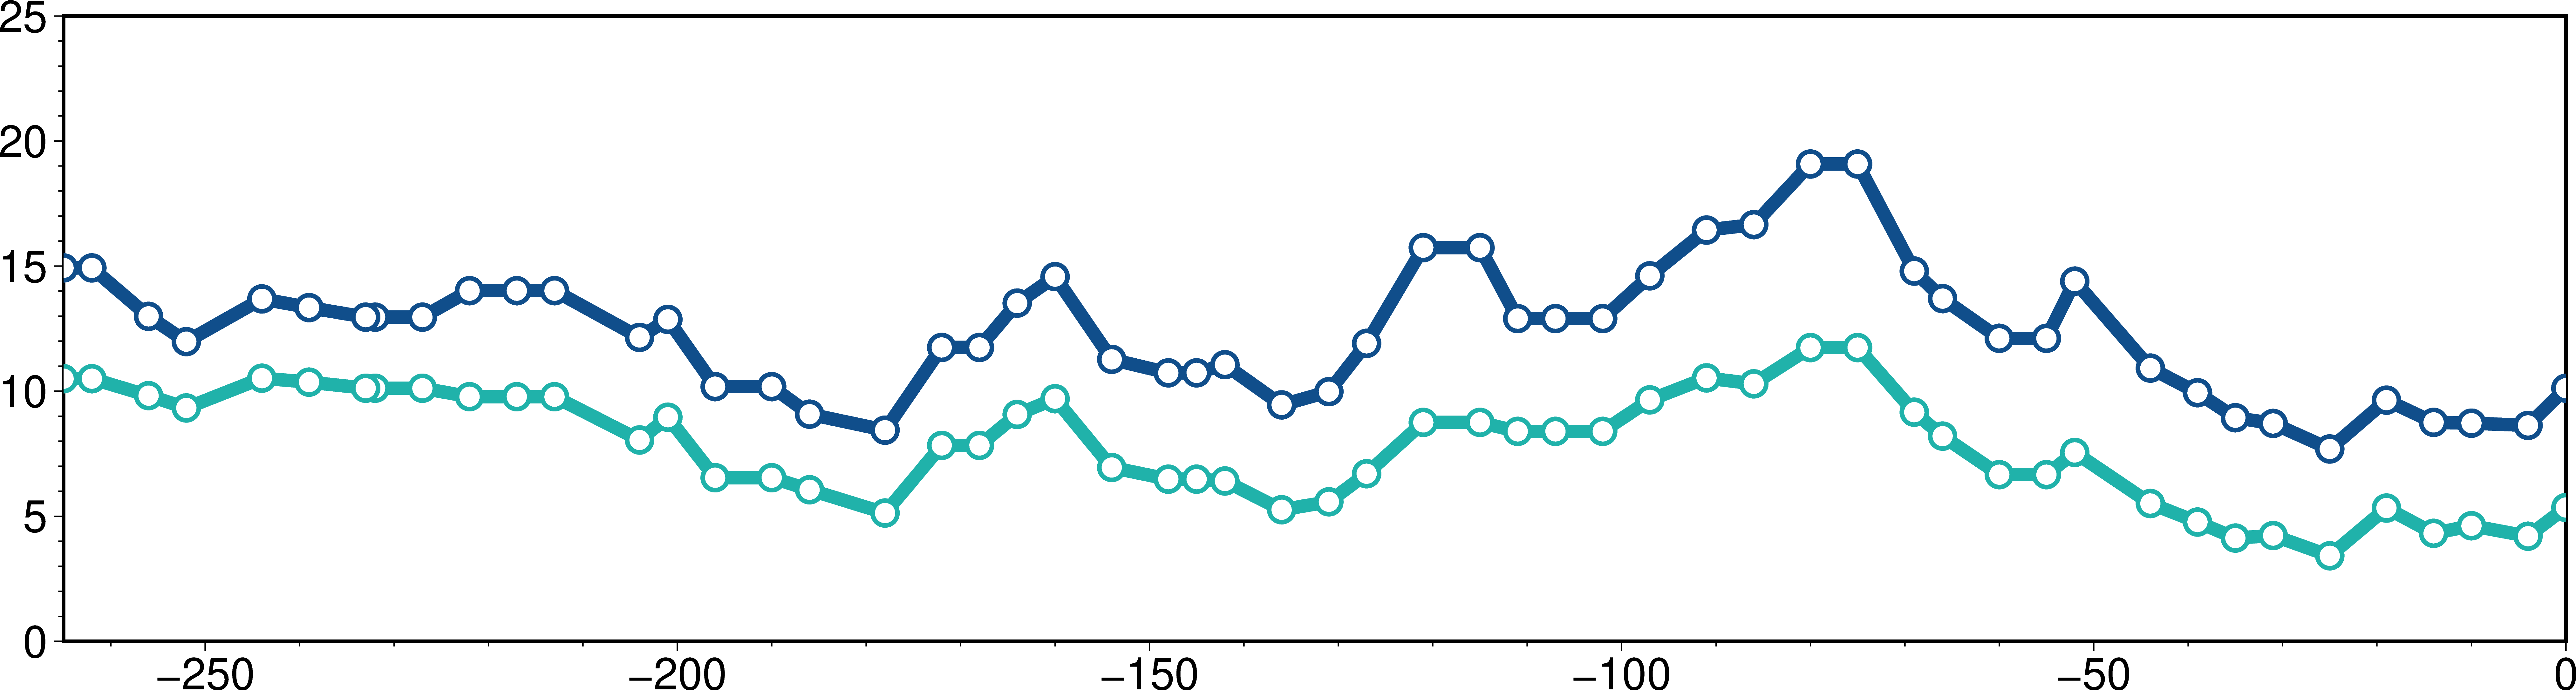

In [21]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-265, 0, 0, 25], projection="X40c/10c", frame='af')
    
#     fig.plot(x=-df['Time (Ma)'],y=tmin,transparency=0,pen="1.5p,darkred")
#     fig.plot(x=-df['Time (Ma)'],y=tmax,transparency=0,pen="1.5p,darkred")
    
#     fig.plot(x=-df['Time (Ma)'],y=smoothdf['SST min'],transparency=0,pen="1.5p,darkorange")
#     fig.plot(x=-df['Time (Ma)'],y=smoothdf['SST max'],transparency=0,pen="1.5p,darkorange")
    
#     fig.plot(
#         frame="a",
#         x=-df['Time (Ma)'],
#         y=df['Tropic Shelf Area vs Earth Area (%)'],
# #         transparency=1,
# #         ='f1c/0.25c+c',
#         style='f1c/0.4c+c+p2p,lightseagreen', fill="white",
#         pen="6p,lightseagreen",
#     )
    
    fig.plot(x=-df['Time (Ma)'],
             y=df['Tropic Shelf Area vs Earth Area (%)'],
             transparency=0,pen="6p,lightseagreen")
    fig.plot(
        x=-df['Time (Ma)'],
        y=df['Tropic Shelf Area vs Earth Area (%)'],
        style="c0.4c", 
        fill="white", 
        pen="2p,lightseagreen",
        transparency=0,
    )
#     
    fig.plot(x=-df['Time (Ma)'],
             y=df['Shelf Area vs Earth Area (%)'],
             transparency=0,
             pen="6p,dodgerblue4")
    
    fig.plot(
        x=-df['Time (Ma)'],
        y=df['Shelf Area vs Earth Area (%)'],
        style="c0.4c", 
        fill="white", 
        pen="2p,dodgerblue4",
        transparency=0,
    )
    
fig.show(dpi=500, width=1000)
fig.savefig('shelfperc.png',dpi=500, transparent=True)

In [294]:
# fig = pygmt.Figure()
# pygmt.config(
#     MAP_FRAME_WIDTH="0.5p",
#     MAP_FRAME_TYPE="fancy",
# )
# font = "4p,Helvetica-Bold"

# df_bound = pd.DataFrame(
#     data={
#         "x": -df['Time (Ma)'],
#         "y": smean,
#         "y_bound_low": smin,
#         "y_bound_upp": smax,
#     }
# )
# with pygmt.config(FONT='20p,Helvetica,black'):
#     fig.basemap(region=[-265, 0, 1, 110], projection="X40c/16cl", frame='af')
#     fig.plot(data=df_bound, close="+b+p0.5p,gray30,dashed", 
#              fill="gray@50", pen="1p,gray30")
#     fig.plot(x=-df['Time (Ma)'],y=smean,transparency=0,pen="5p")
# fig.show(dpi=500, width=1000)

In [275]:
ncdata1 = xr.open_dataset('suitability_Foster.nc')
suitabilityFoster = ncdata1.where(ncdata1.cubic>0).cubic

In [276]:
ncdata2 = xr.open_dataset('suitability_Smooth.nc')
suitabilitySmooth = ncdata2.where(ncdata2.cubic>0).cubic

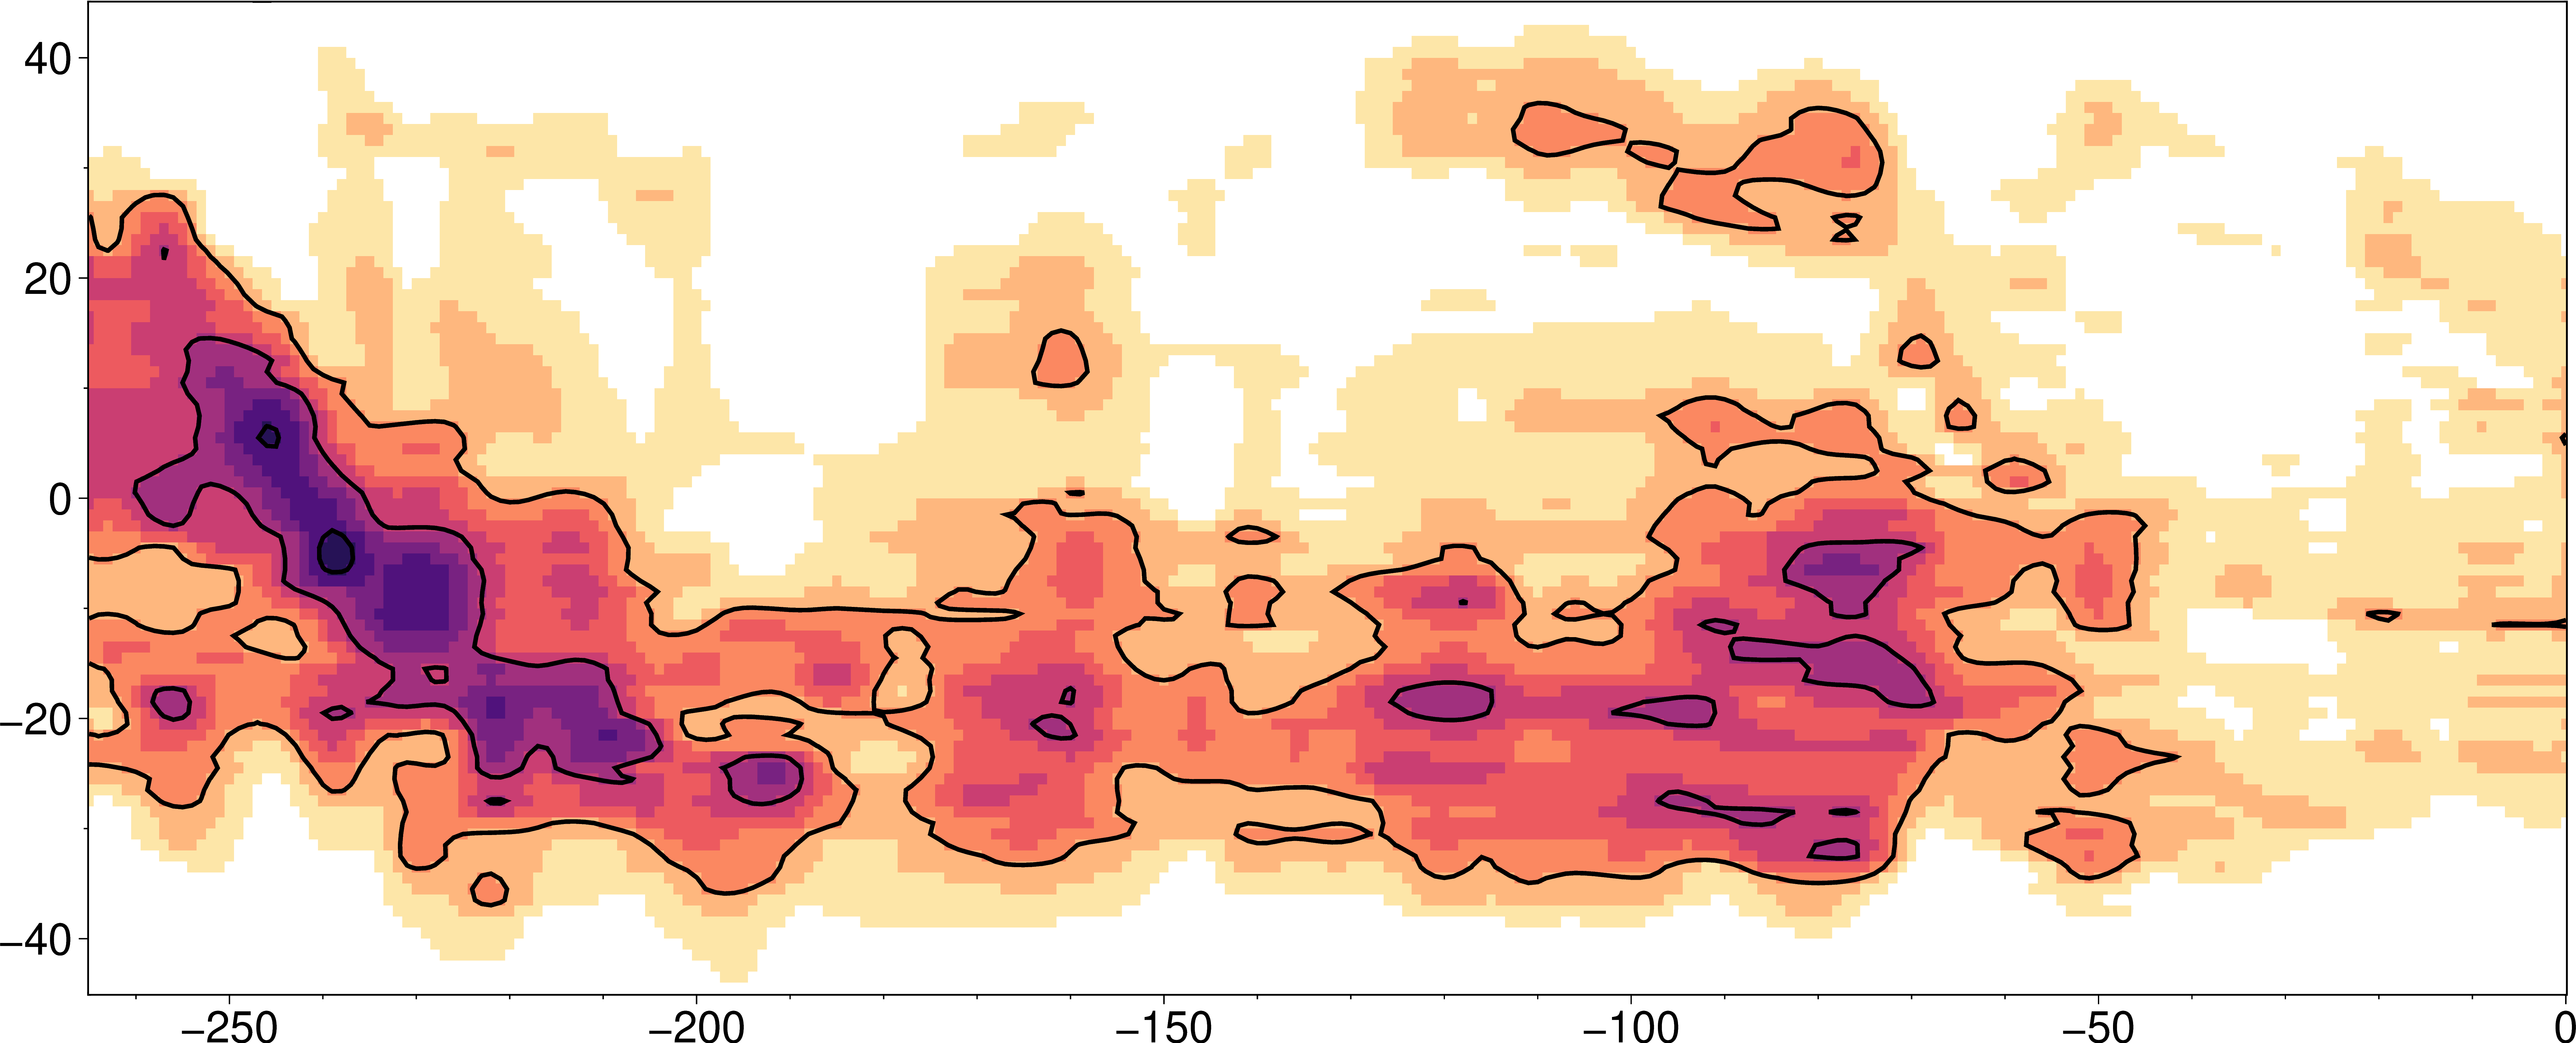

In [277]:
# Plot figure
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black',COLOR_BACKGROUND="white"):
    fig.basemap(region=[-265, 0, -45, 45], projection="X40c/16c", frame='af')
    pygmt.makecpt(cmap="magma", series=[1, 11,1], reverse=True, 
                  )
    fig.grdimage(
        grid=suitabilityFoster, cmap=True, nan_transparent=True# M=True
    )
#     fig.colorbar(position="JMR")
    
    fig.grdcontour(
#         annotation="1+f18p",
        interval=3,
        grid=suitabilityFoster,
        pen="2p,black",
        
    )
fig.show(dpi=500, width=1000)
fig.savefig('suitability_Foster.png',dpi=500, transparent=True)

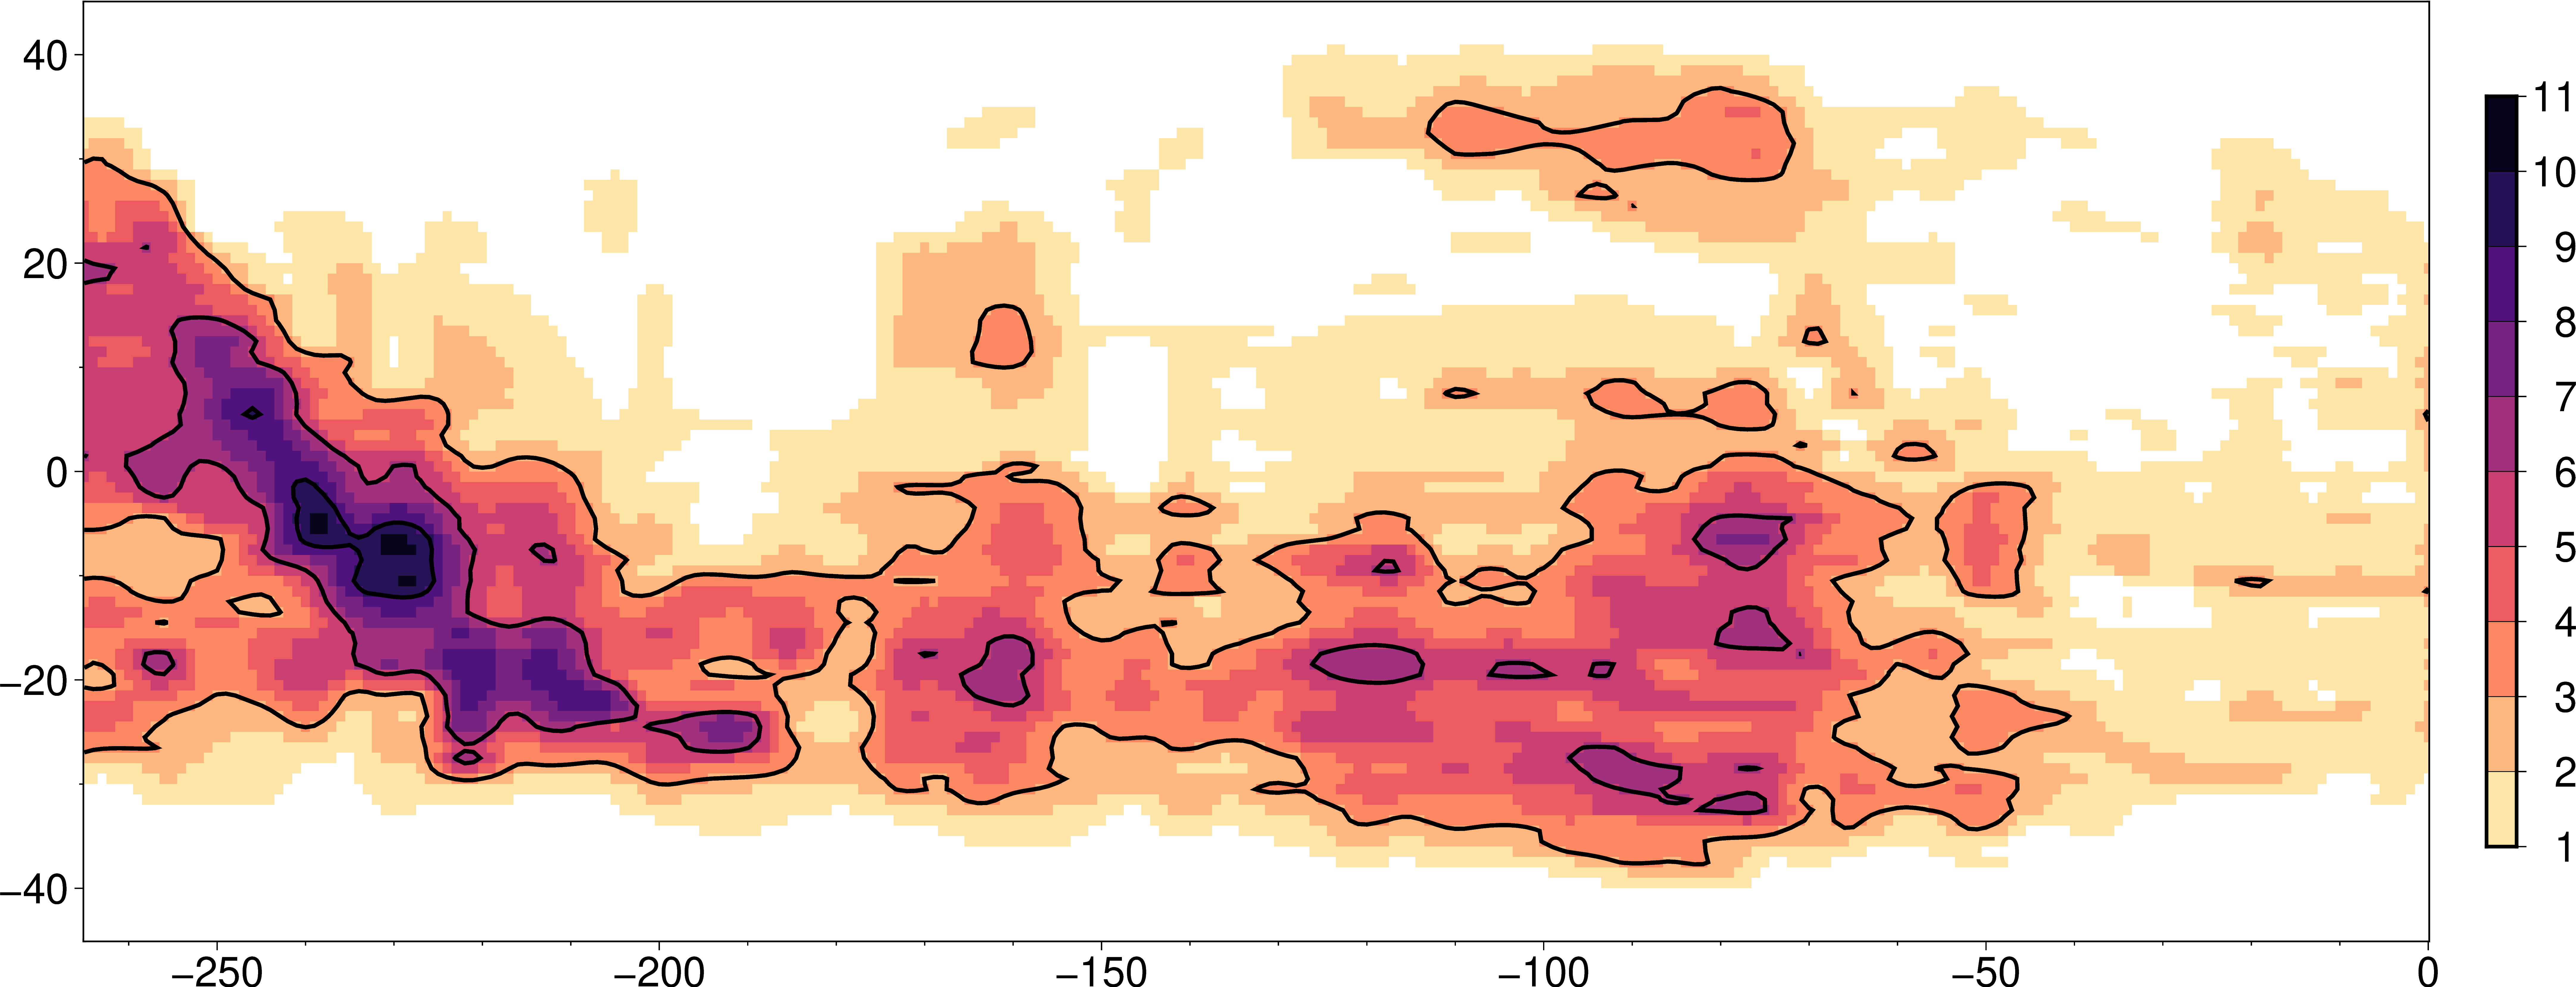

In [315]:
# Plot figure
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black',COLOR_BACKGROUND="white"):
    fig.basemap(region=[-265, 0, -45, 45], projection="X40c/16c", frame='af')
    pygmt.makecpt(cmap="magma", series=[1, 11,1], reverse=True, 
                  )
    fig.grdimage(
        grid=suitabilitySmooth, cmap=True, nan_transparent=True# M=True
    )
#     fig.colorbar(position="JMR")
    
    fig.grdcontour(
#         annotation="1+f18p",
        interval=3,
        grid=suitabilitySmooth,
        pen="2p,black",
        
    )
fig.show(dpi=500, width=1000)
fig.savefig('suitability_Smooth.png',dpi=500, transparent=True)

In [295]:
# suitability = ncdata1.where(ncdata1.linear>0.5).linear
# fig = pygmt.Figure()
# pygmt.config(
#     MAP_FRAME_WIDTH="0.5p",
#     MAP_FRAME_TYPE="fancy",
# )
# font = "4p,Helvetica-Bold"

# with pygmt.config(FONT='20p,Helvetica,black',COLOR_BACKGROUND="white"):
#     fig.basemap(region=[-265, 0, -60, 60], projection="X40c/16c", frame='af')
#     pygmt.makecpt(cmap="panoply", series=[0, 10], reverse=False, 
#                   )
#     fig.grdimage(
#         grid=suitability, cmap=True, nan_transparent=True# M=True
#     )
#     fig.colorbar(position="JMR")
    
#     fig.grdcontour(
# #         annotation="1+f18p",
#         interval=3,
#         grid=suitability,
#         pen="2p,black",
        
#     )
# #fig.savefig(fname="freq_over_time.png")
# fig.show(dpi=500, width=1000)